# Loneliness index and health and disability deprivation exploration

In [1]:
import pandas as pd

In [2]:
loneliness_imd = pd.read_csv('england/loneliness_imd.csv')
loneliness_imd.drop(6270, inplace=True)
imd = pd.read_csv('england/imd2015eng.csv')
full_loneliness = pd.read_csv('england/final_data.csv')

In [3]:
for c in list(loneliness_imd.columns):
    print(c)

lsoa11
year
loneills
msoa11
lsoa_code
lsoa_name
district_code
district_name
imd_score
imd_rank
imd_decile
income_score
income_rank
income_decile
employment_rate
employment_score
employment_decile
education_score
education_rank
education_decile
health_score
health_rank
health_decile
crime_score
crime_rank
crime_decile
housing_score
housing_rank
housing_decile
living_score
living_rank
living_decile
poor_children_score
poor_children_rank
poor_children_decile
poor_older_score
poor_older_rank
poor_older_decile
young_sub_score
young_sub_rank
young_sub_decile
adult_skills_sub_score
adult_skills_sub_rank
adult_skills_sub_decile
geog_barriers_sub_score
geog_barriers_sub_rank
geog_barriers_sub_decile
wider_barriers_sub_score
wider_barriers_sub_rank
wider_barriers_sub_decile
indoor_sub_score
indoor_sub_rank
indoor_sub_decile
outdoor_sub_score
outdoor_sub_rank
outdoor_sub_decile
total_population
aged_under_15_population
aged_16-59_population
aged_over_60_population
working_age_population


In [4]:
desired_columns = [
    'lsoa11', 'year', 'lsoa_code', 'lsoa_name', 'district_code', 'district_name',
    'loneills',
    'imd_score', 'imd_rank', 'imd_decile',
    'health_score', 'health_rank', 'health_decile',
    'aged_under_15_population', 'aged_16-59_population', 'aged_over_60_population', 'total_population'
]

loneliness_health = loneliness_imd.filter(desired_columns, axis=1)
print(loneliness_health.shape)

(6270, 17)


## Health score and loneliness index

In [5]:
import plotly.express as px

In [6]:
fig = px.scatter(loneliness_health, y='loneills', x='health_score', title='IMD Health Score vs loneliness index')
fig.show()

In [7]:
fig = px.scatter(loneliness_health, y='imd_score', x='health_score', title='IMD Health Score vs IMD score')
fig.show()

In [8]:
loneliness_health[['imd_score', 'health_score', 'loneills']].corr()

imd_score  health_score  loneills
imd_score      1.000000      0.856076 -0.173878
health_score   0.856076      1.000000 -0.133275
loneills      -0.173878     -0.133275  1.000000

So the health deprivation score doesn't appear strongly correlated with loneliness but there's a fairly strong correlation between health and overall IMD score (unsurprising given IMD score is 13.5% of the IMD score).

This doesn't match the ONS findings based on data collected for the Community Life Survey (CLS) between August 2016 and March 2017: "People in poor health or who have conditions they describe as “limiting” were also at particular risk of feeling lonely more often." - https://www.ons.gov.uk/peoplepopulationandcommunity/wellbeing/articles/lonelinesswhatcharacteristicsandcircumstancesareassociatedwithfeelinglonely/2018-04-10

## Health and loneliness deciles

Maybe the raw scores are too varied to show much relationship but perhaps there's a tendancy for worse health scores to the related to worse loneliness scores

In [9]:
loneliness_health['loneills_decile'] = pd.qcut(loneliness_health['loneills'], 10, labels=False)+1.0

In [10]:
loneliness_health[['loneills_decile', 'health_decile']]

loneills_decile  health_decile
0                 1.0            4.0
1                 1.0            3.0
2                 3.0            5.0
3                 2.0            6.0
4                 4.0            2.0
...               ...            ...
6265              4.0            5.0
6266              4.0            1.0
6267              2.0            1.0
6268              9.0            1.0
6269              6.0            1.0

[6270 rows x 2 columns]

In [11]:
decile_counts = loneliness_health.value_counts(subset=['loneills_decile', 'health_decile'])
decile_counts = pd.DataFrame(decile_counts.values, index=decile_counts.index, columns=['count'])
decile_counts.reset_index(inplace=True)
decile_counts = decile_counts.pivot(index='loneills_decile', columns='health_decile', values='count')

In [12]:
decile_counts

health_decile    1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0
loneills_decile                                                            
1.0               102   111   112    72    58    50    42    29    25    26
2.0                91    97    95    55    74    48    56    35    44    32
3.0                81    83    82    61    68    77    59    44    47    25
4.0                93    79    76    67    68    58    66    53    25    42
5.0                91    58    83    73    82    55    51    53    47    34
6.0                98    65    83    61    82    56    50    49    41    42
7.0                76    56    57    65    66    65    60    69    62    51
8.0                93    55    60    65    76    54    58    57    59    50
9.0                77    61    65    54    50    57    54    63    74    72
10.0               62    41    54    71    67    52    55    59    74    92

In [13]:
fig = px.imshow(decile_counts)
fig.show()

There's definitely a "hotspot" for top loneills and top health deciles (and corresponding deadspot of few low top loneills deciles amongst the lower ranked health deciles). But otherwise if seems fairly smudgy.

## Local Authority level analysis

Take similar approach as above but aggregate at LA level rather than LSOA.

In [14]:
agg_cols = {}

for key in ['imd_score', 'health_score', 'loneills']:
    agg_cols[key] = 'mean'

for key in ['aged_under_15_population', 'aged_16-59_population', 'aged_over_60_population', 'total_population']:
    agg_cols[key] = 'sum'
    
for key in ['district_name']:
    agg_cols[key] = 'first'
    
la_loneliness_health = loneliness_health.groupby(['district_code'], as_index=False).agg(agg_cols)

In [15]:
fig = px.scatter(la_loneliness_health, y='loneills', x='health_score', title='IMD Health Score vs loneliness index at Local Authority level')
fig.show()

In [16]:
la_loneliness_health[['imd_score', 'health_score', 'loneills']].corr()

imd_score  health_score  loneills
imd_score      1.000000      0.913813 -0.259564
health_score   0.913813      1.000000 -0.187583
loneills      -0.259564     -0.187583  1.000000

In [17]:
def add_quantiles(df, n, columns):
    for column in columns:
        df[f'{column}_{n}-quantile'] = pd.qcut(df[column], n, labels=False)+1.0

add_quantiles(la_loneliness_health, 5, ['imd_score', 'health_score', 'loneills'])

In [18]:
def count_matrix(df, col1, col2):
    counts = df.value_counts(subset=[col1, col2])
    counts = pd.DataFrame(counts.values, index=counts.index, columns=['count'])
    counts.reset_index(inplace=True)
    counts = counts.pivot(index=col1, columns=col2, values='count')
    
    return counts

la_loneliness_health_quantile_counts = count_matrix(la_loneliness_health, 'loneills_5-quantile', 'health_score_5-quantile')

In [19]:
la_loneliness_health_quantile_counts

health_score_5-quantile  1.0  2.0  3.0  4.0  5.0
loneills_5-quantile                             
1.0                       11   14   13    9   19
2.0                        4    6   20   13   22
3.0                       13   16   10   16   10
4.0                       17   16    7   17    8
5.0                       21   13   15   10    6

In [20]:
fig = px.imshow(la_loneliness_health_quantile_counts)
fig.show()

While aggregating data at a local authority level (mean of scores for all LSOAs in LA) removes some of the outliers, no clear relationships between health deprivation and the loneliness index are apparent.

## Simple linear models: loneills score from IMD domain scores

In [21]:
import sklearn
from sklearn import linear_model

In [22]:
reg = linear_model.LinearRegression()

X = loneliness_imd[['income_score', 'employment_score', 'education_score', 'health_score', 'crime_score', 'housing_score', 'living_score', 'poor_children_score', 'poor_older_score']]
y = loneliness_imd['loneills']

reg.fit(X, y)

reg.score(X, y)

0.0806287152311157

In [23]:
reg = linear_model.LinearRegression()

X = loneliness_imd[['income_score', 'employment_score', 'education_score', 'crime_score', 'housing_score', 'living_score', 'poor_children_score', 'poor_older_score']]
y = loneliness_imd['loneills']

reg.fit(X, y)

reg.score(X, y)

0.07305214368835711

So health score definitely helps with the fit but neither are great.

In [24]:
fig = px.scatter(loneliness_health, y='loneills', x='health_score', title='IMD Health Score vs loneliness index')
fig.show()

## Bivariate health and loneliness plots

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib

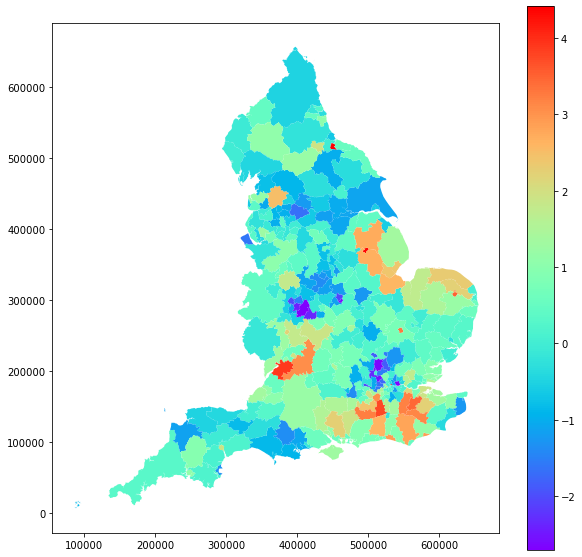

In [26]:
agg_cols = {'loneills': 'mean'}

la_loneliness_imd = loneliness_health.groupby(['district_code'], as_index=False).agg(agg_cols)

la_shapes =  gpd.read_file('england/Local_Authority_Districts_(December_2015)_Boundaries/Local_Authority_Districts_(December_2015)_Boundaries.shp')
la_geo_loneliness_imd = la_shapes.merge(la_loneliness_imd, how='inner', left_on=['lad15cd'], right_on=['district_code'])

fig, ax = plt.subplots(figsize = (10,10))
la_geo_loneliness_imd.plot(column='loneills', cmap='rainbow', ax=ax, legend = True)

fig.savefig('england/la_loneills.png')


In [27]:
loneliness_health['loneills_trentile'] = pd.qcut(loneliness_health['loneills'], 3, labels=False)+1
loneliness_health['health_trentile'] = pd.qcut(loneliness_health['health_score'], 3, labels=False)+1

In [47]:
colour_map = ['#e8e8e8', '#e4acac', '#c85a5a', '#b0d5df', '#ad9ea5', '#985356', '#64acbe', '#627f8c', '#574249']
colour_map = ['#e8e8e8', '#b5c0da', '#6c83b5', '#b8d6be', '#90b2b3', '#567994', '#73ae80', '#5a9178', '#2a5a5b']

cmap = matplotlib.colors.ListedColormap(colour_map)
loneliness_health['bivariate_lone_health_colour_index'] = loneliness_health.apply(lambda x: 3*(x['loneills_trentile']-1) + x['health_trentile'], axis=1)
loneliness_health['bivariate_lone_health_colour'] = loneliness_health.apply(lambda x: colour_map[x['bivariate_lone_health_colour_index']-1], axis=1)

In [29]:
loneliness_health[['lsoa11', 'district_code', 'loneills', 'health_score', 'loneills_trentile', 'health_trentile', 'bivariate_lone_health_colour', 'bivariate_lone_health_colour_index']]

lsoa11 district_code  loneills  health_score  loneills_trentile  \
0     E01000007     E09000002 -3.032939         0.251                  1   
1     E01000009     E09000002 -6.786468         0.526                  1   
2     E01000010     E09000002 -1.346273         0.139                  1   
3     E01000012     E09000002 -2.063601        -0.114                  1   
4     E01000017     E09000002 -0.972582         0.888                  1   
...         ...           ...       ...           ...                ...   
6265  E01033746     E09000011 -0.780173         0.063                  2   
6266  E01033758     E08000012 -0.932807         2.262                  1   
6267  E01033759     E08000012 -2.025628         1.811                  1   
6268  E01033762     E08000012  1.970892         1.467                  3   
6269  E01033764     E08000012  0.166426         2.731                  2   

      health_trentile bivariate_lone_health_colour  \
0                   2                      #e4acac   
1                   2                      #e4acac   
2                   2                      #e4acac   
3                   2                      #e4acac   
4                   3                      #c85a5a   
...               ...                          ...   
6265                2                      #ad9ea5   
6266                3                      #c85a5a   
6267                3                      #c85a5a   
6268                3                      #574249   
6269                3                      #985356   

      bivariate_lone_health_colour_index  
0                                      2  
1                                      2  
2                                      2  
3                                      2  
4                                      3  
...                                  ...  
6265                                   5  
6266                                   3  
6267                                   3  
6268                                   9  
6269                                   6  

[6270 rows x 8 columns]

<AxesSubplot:xlabel='loneills', ylabel='health_score'>

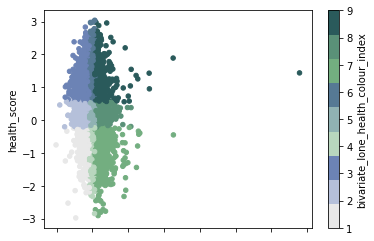

In [48]:
loneliness_health.plot.scatter('loneills', 'health_score', c='bivariate_lone_health_colour_index', cmap=cmap)

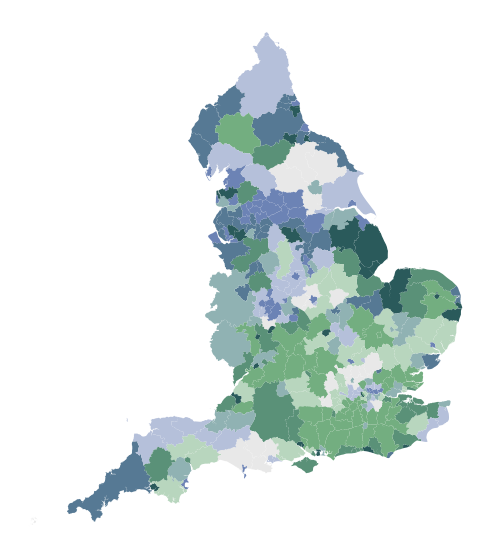

In [49]:
agg_cols = {'loneills': 'mean', 'health_score': 'mean'}

la_loneliness_imd = loneliness_health.groupby(['district_code'], as_index=False).agg(agg_cols)

la_loneliness_imd['loneills_trentile'] = pd.qcut(la_loneliness_imd['loneills'], 3, labels=False)+1
la_loneliness_imd['health_trentile'] = pd.qcut(la_loneliness_imd['health_score'], 3, labels=False)+1

la_loneliness_imd['bivariate_lone_health_colour_index'] = la_loneliness_imd.apply(lambda x: 3*(x['loneills_trentile']-1) + x['health_trentile'], axis=1)

la_shapes =  gpd.read_file('england/Local_Authority_Districts_(December_2015)_Boundaries/Local_Authority_Districts_(December_2015)_Boundaries.shp')
la_geo_loneliness_imd = la_shapes.merge(la_loneliness_imd, how='inner', left_on=['lad15cd'], right_on=['district_code'])

fig, ax = plt.subplots(figsize = (10,10))
ax.set_axis_off()
la_geo_loneliness_imd.plot(column='bivariate_lone_health_colour_index', cmap=cmap, ax=ax)

fig.savefig('england/la_health_loneliness_bivar_choropleth.png')

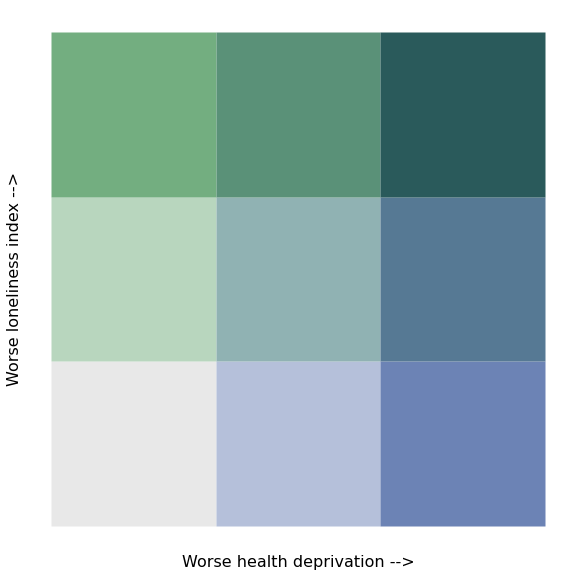

In [50]:
fig, ax = plt.subplots(figsize = (10,10))

rect_list=[]

def draw_legend(ax, fontsize=16):
    for i in range(0,3):
        for j in range(0,3):
            rectangle = plt.Rectangle((i,j), 1, 1, fc=colour_map[i + j*3])
            rect_list.append(rectangle)

    patches = matplotlib.collections.PatchCollection(rect_list, match_original=True)
    # ax.set_axis_off()
    ax.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('Worse health deprivation -->', fontsize = fontsize)
    ax.set_ylabel('Worse loneliness index -->',  fontsize = fontsize)
    ax.add_collection(patches)

draw_legend(ax)
plt.axis('scaled')
plt.show()

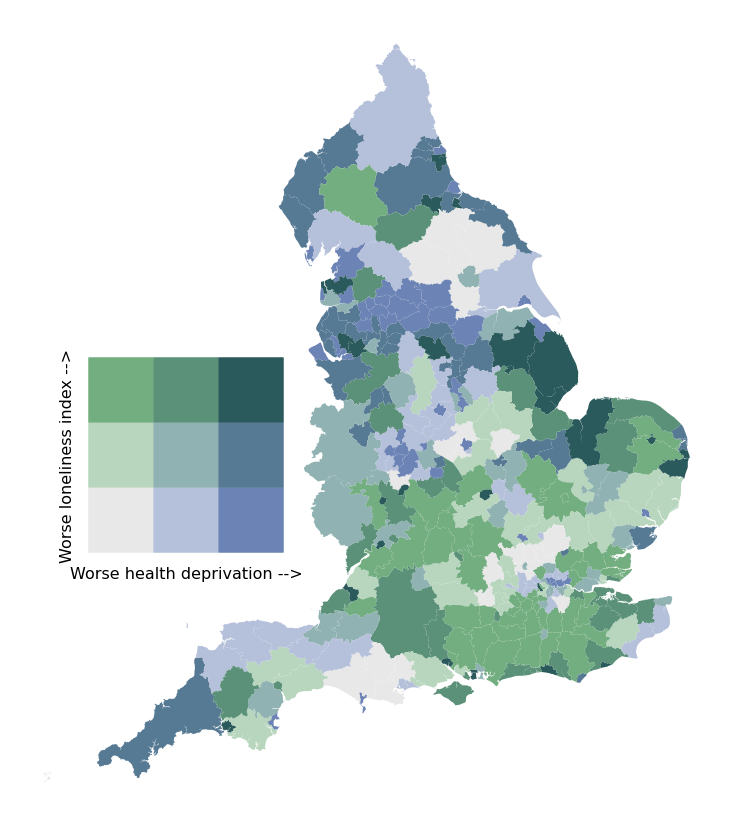

In [51]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize = (15,15))
ax.set_axis_off()

# Create inset of width 1.3 inches and height 0.9 inches
# at the default upper right location
# axins = inset_axes(ax, width=1.5, height=1.5)

axins = inset_axes(ax, width="50%", height="50%",
                   bbox_to_anchor=(0.1, 0, .6, .6),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)

la_geo_loneliness_imd.plot(column='bivariate_lone_health_colour_index', cmap=cmap, ax=ax)

draw_legend(axins, fontsize=16)

plt.axis('scaled')
plt.show()
fig.savefig('england/la_health_loneliness_bivar_choropleth.png')
